# Injuries in Collision Prediction

In [2]:
import warnings
import collisionfuncs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collision_model_features import CollisionFeature, TrafficFeature
from sklearn import model_selection, linear_model, discriminant_analysis, ensemble, metrics
warnings.filterwarnings('ignore')
pd.set_option('display.float_format','{:.2f}'.format)
random_state=42

## Read data
+ use CollisionFeature, TrafficFeature to get three data sets for modeling
    + collisions
    + traffic_byhour
    + traffic_bydayofweek

In [11]:
path = '../matched_data/crash_matched_data'

collisions = pd.read_csv(
    path + '/collisions_matched.tsv', sep='\t')
traffic_matched = pd.read_csv(
    path + '/traffic_matched.csv')
speed_limits_matched = pd.read_csv(
    path + '/speed_limits_matched.csv')
speed_bumps_matched = pd.read_csv(
    path + '/speed_bumps_matched.csv')
bike_lanes_matched = pd.read_csv(
    path + '/bike_lanes_matched.csv')

# Create features
# Use the CollisionFreature class from collision_model_features.py to add 3 indicator variables for speed bumps, speed limits, and bike lanes to the collisions table
feature = CollisionFeature(
    collisions, speed_bumps_matched, speed_limits_matched, bike_lanes_matched)
feature.speed_bumps()
feature.speed_limit()
feature.bike_lanes()
collisions = feature.collisions

# Use the TrafficFeature class to get the traffic volumes
traffic_feature = TrafficFeature(traffic_matched)
traffic_byhour = traffic_feature.traffic_byhour()
traffic_bydayofweek = traffic_feature.traffic_bydayofweek()

In [12]:
# merge collisions dataset and two traffic datasets
# there may be missing values after joining, because only limited traffic volumes were only recorded on limited days
collisions = pd.merge(left=collisions, right=traffic_bydayofweek, how='left', on=['streetID','dayofweek'])
collisions = pd.merge(left=collisions, right=traffic_byhour, how='left', on=['streetID', 'time'])
collisions = collisions.dropna(subset = ['medianWeek', 'medianHour'])

# select columns that will be used in the model
# collisions = collisions.loc[:,['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
#        'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
#        'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
#        'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 
#        'dayofweek', 'time', 'speed_bumps', 'speed_limits',
#        'bike_lanes', 'medianWeek', 'medianHour']]
# collisions.info()

In [13]:
collisions.columns

Index(['collision_id', 'CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME',
       'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'coords', 'index_right', 'Roadway.Name', 'From', 'To', 'int1', 'int2',
       'zip1', 'zip2', 'll1', 'll2', 'streetID', 'lat1', 'long1', 'lat2',
       'long2', 'dayofweek', 'time', 'speed_bumps', 'speed_limits',
       

In [14]:
# check if the dataset is imbalanced
print([sum(collisions['NUMBER OF PERSONS INJURED'] == 0), sum(collisions['NUMBER OF PERSONS INJURED'] > 0)])
# use undersampling to cut the number of rows for  NUMBER OF PERSONS INJURED == 0.
noinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 0].sample(n=30000,random_state=random_state)
oneinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 1].sample(n=30000,random_state=random_state)
twoinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] == 2]
moreinjuries = collisions.loc[collisions['NUMBER OF PERSONS INJURED'] > 2]
moreinjuries['NUMBER OF PERSONS INJURED'] = 3
collisions = pd.concat([noinjuries, oneinjuries, twoinjuries, moreinjuries])

[721455, 223328]


## Number of injuries prediction
+ Question: how many people will get injured in a collision given the hour, day of the week, if there is speed bumps, speed limits, bike lanes, and the estimation of traffic of that street.
+ Classification problem: the outcome variable is a categorical variable. 0 people get injured, 1 people get injured, 2 people get injured, and more than 3 people get injured.
+ Method: random forest

<AxesSubplot: ylabel='Count'>

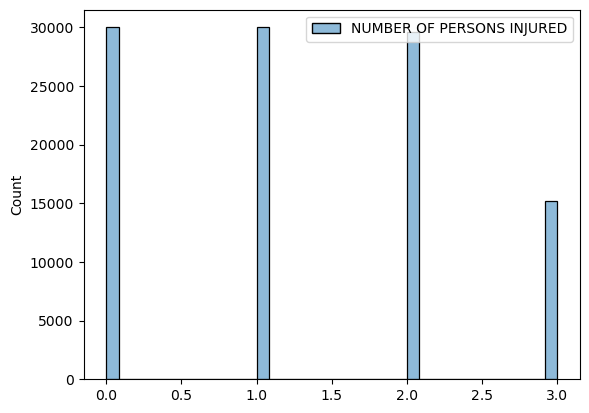

In [15]:
X = collisions.loc[:,['dayofweek', 'time', 'speed_bumps', 'speed_limits', 'bike_lanes', 'medianWeek', 'medianHour']]
y = collisions.loc[:,['NUMBER OF PERSONS INJURED']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=random_state)
# seaborn histogram
sns.histplot(y)

In [8]:
# # bad fittings
# # I tried to predict the number of injuried, but couldn't get a good fitting. Thus, I redefined a classification problem.
# linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))

# Multiclass LDA
clf = discriminant_analysis.LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.005678898085881956
0.3167532485240179


In [9]:
# random forest
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.8945473882275944
0.7750771482200235


### Visualization

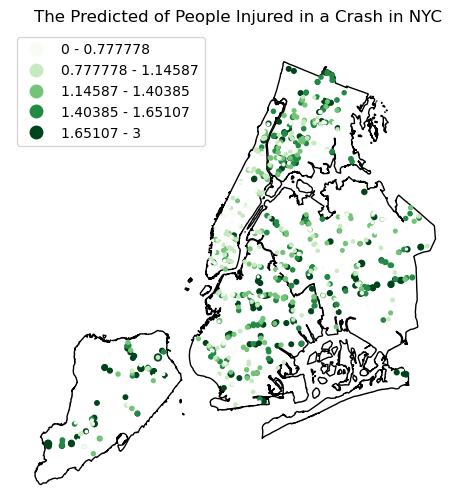

In [19]:
# predicted injuries
y_pred = rf.predict(X)
collisions['NUMBER OF PERSONS INJURED'] = y_pred
analysis = ['NUMBER OF PERSONS INJURED']
titles = ['The Predicted of People Injured in a Crash in NYC']
for i in range(len(analysis)):
    collisionfuncs.pointplot(collisions, analysis[i], titles[i])
    plt.savefig('report_and_slides/pics/' + titles[i] + '.jpg')